In [1]:
import torch
import numpy as np
import h5py as h5
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from pathlib import Path
import isle

from Misc import read_params, makeIsleParams, get_fn, writeParamsH5, make_action, overview
from ML_Layer import LinearTransformation, AffineCoupling, Equivariance, PRCL, Sequential, Flow
from ML_Loss import Integrator, IntegrateHolomorphicFlowLoss
from ML_Training import train

# ToDo :)
# from Analysis import field_statistic

from HMC import ML_HMC, HMC
from Correlators import measure_correlators, estimate_correlators, estimate_statistical_power
from Hubbard2SiteModel import Hubbard2SiteModel
from RungeKutta import singleRK4Step

In [2]:
import isle.plotting
isle.plotting.setupMPL()

# define FZJ cooperate colors
BLUE      = (  2/255, 61/255,107/255)
LIGHTBLUE = (173/255,189/255,227/255)
GRAY      = (235/255,235/255,235/255)
RED       = (235/255, 95/255,115/255)
GREEN     = (185/255,210/255, 95/255)
YELLOW    = (250/255,235/255, 90/255)
VIOLET    = (175/255,130/255,185/255)
ORANGE    = (250/255,180/255, 90/255)
WHITE     = (255/255,255/255,255/255)

# Parameters

The following parameters define the setup of the training and model to be simulated

In [3]:
# params = {
#     # model parameters
#     "Nt": 32,
#     "beta": 4,
#     "U": 4,
#     "mu": 3,
#     "lattice": "two_sites",
#     "Nx": 2,
#     "Tangent Plane Offset": -0.249966501,
#     # Neural Network parameters
#     "Number Internal Layers": 2,
#     # For further definitions, like activation functions etc. 
#     # refer to function `create_model`
#     # Flow parameters
#     "Number Flow Steps": 2,
#     "Flow Step Size": 0.01,
#     # Training data parameters
#     "Ntrain": {
#         "RK4": 10_000, # Runge-Kutta phase
#         "FI" : 1000,  # Full Integration phase
#     },
#     "Nvalid": {
#         "RK4": 1000, # Runge-Kutta phase
#         "FI" : 100,  # Full Integration phase
#     },
#     "Ntest": 1000,
#     # Training parameters
#     "Learning Rate": {
#         "RK4": 1e-4, # Runge-Kutta phase
#         "FI" : 1e-4,  # Full Integration phase
#     },
#     "Number Epochs": {
#         "RK4": 200, # Runge-Kutta phase
#         "FI" : 50,  # Full Integration phase
#     },
#     # For the isle algorithms
#     "sigmaKappa": -1,
#     "hopping": isle.action.HFAHopping.EXP,
#     "basis": isle.action.HFABasis.PARTICLE_HOLE,
#     "algorithm": isle.action.HFAAlgorithm.DIRECT_SINGLE,
# }

params = read_params("ParameterFiles/paramExample.json")

for key in params.keys():
    print(f"{key: <22}: {params[key]}")

Nt                    : 32
beta                  : 4
U                     : 4
mu                    : 3
lattice               : two_sites
Nx                    : 2
Tangent Plane Offset  : -0.249966501
Number Internal Layers: 2
Number Flow Steps     : 2
Flow Step Size        : 0.01
Ntrain                : {'RK4': 10000, 'FI': 1000}
Nvalid                : {'RK4': 1000, 'FI': 100}
Ntest                 : 1000
Learning Rate         : {'RK4': 0.0001, 'FI': 0.0001}
Number Epochs         : {'RK4': 200, 'FI': 50}
sigmaKappa            : -1
hopping               : HFAHopping.EXP
basis                 : HFABasis.PARTICLE_HOLE
algorithm             : HFAAlgorithm.DIRECT_SINGLE


In [8]:
HM = Hubbard2SiteModel(
    Nt = params['Nt'],
    beta = params['beta'],
    U = params['U'],
    mu = params['mu'],
    tangentPlaneOffset = params['Tangent Plane Offset'] 
)

# Runge-Kutta of $4^{\mathrm{th}}$ Order

To train the network a single integration step we utilize the Runge-Kutta of $4^{\mathrm{th}}$ order (RK4). 
Thus the training data is generated with the following RK4 step:

# Generate Training Data

## RK4 Phase

In [14]:
%%time

# Training Data
trainData_RK4 = torch.randn(size = (params['Ntrain']['RK4'],HM.Nt,HM.Nx), dtype = torch.double) + 1j*HM.tangentPlaneOffset
trainTargetData_RK4 = singleRK4Step(params['Flow Step Size'], trainData_RK4, HM)
trainDataset_RK4 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(trainData_RK4, trainTargetData_RK4),
    batch_size = params['Ntrain']['RK4']
)


# Validation Data
validData_RK4 = torch.randn(size = (params['Nvalid']['RK4'],HM.Nt,HM.Nx), dtype = torch.double) + 1j*HM.tangentPlaneOffset
validTargetData_RK4 = singleRK4Step(params['Flow Step Size'], validData_RK4, HM)
validDataset_RK4 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(validData_RK4, validTargetData_RK4),
    batch_size = params['Nvalid']['RK4']
)

CPU times: user 30.6 s, sys: 3.33 ms, total: 30.6 s
Wall time: 30.2 s


## Full Integration Phase

This could also be done during the training on the fly changing with every epoch (we have to experiment with that!).

In [15]:
%%time

# Training Data
trainData_FI = torch.randn(size = (params['Ntrain']['FI'],HM.Nt,HM.Nx), dtype = torch.double) + 1j*HM.tangentPlaneOffset
trainDataset_FI = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(trainData_FI),
    batch_size = params['Ntrain']['FI']

)

# Validation Data
validData_FI = torch.randn(size = (params['Ntrain']['FI'],HM.Nt,HM.Nx), dtype = torch.double) + 1j*HM.tangentPlaneOffset
validDataset_FI = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(validData_FI),
    batch_size = params['Ntrain']['FI']                                         
)

CPU times: user 9.49 ms, sys: 0 ns, total: 9.49 ms
Wall time: 5.89 ms


# Generate Test Data

In [31]:
%%time
# Testing data
testData = torch.randn(size = (params['Ntest'],HM.Nt,HM.Nx), dtype = torch.double) + 1j*HM.tangentPlaneOffset
testTargetData = singleRK4Step(params['Flow Step Size'], testData, HM)

CPU times: user 2.81 s, sys: 0 ns, total: 2.81 s
Wall time: 2.64 s


# Prepare Model

One PRACL layer being trained for a single RK4 step.
We might want to update the coupling from an Affine Copling to something more related 

In [17]:
def create_model(params):
    def param_factory():
        nn = []
        for _ in range(1,params['Number Internal Layers']):
            # NxLayer = Nx/2 = 1 
            L = LinearTransformation(Nt = HM.Nt, Nx = HM.Nx//2)
            torch.nn.init.zeros_(L.weight)
            torch.nn.init.zeros_(L.bias)
        
            nn.append(L)
            nn.append(torch.nn.Softsign())
        
        L = LinearTransformation(Nt = HM.Nt, Nx = HM.Nx//2)
        torch.nn.init.zeros_(L.weight)
        torch.nn.init.zeros_(L.bias)
        
        nn.append(L)
        return torch.nn.Sequential(*nn)
    
    def PRCL_factory():
        return PRCL(
            Nt = HM.Nt, 
            Nx = HM.Nx, 
            coupling = AffineCoupling(
                m = param_factory(),
                a = param_factory()
            )
        )
    
    return Equivariance(PRCL_factory())

NN = create_model(params)
print(NN)

Equivariance(
  (NN): PRCL(
    (coupling): AffineCoupling(
      (m): Sequential(
        (0): LinearTransformation()
        (1): Softsign()
        (2): LinearTransformation()
      )
      (a): Sequential(
        (0): LinearTransformation()
        (1): Softsign()
        (2): LinearTransformation()
      )
    )
  )
)


# Prepare Flow

Multiplical applications of NN

In [18]:
flow = Flow(NN, params['Number Flow Steps'])
# This is set by default. We should anyway make sure that the flow is in training mode as it has different behaviour 
# as in the evaluation mode
flow.train(True)

Flow(
  (NN): Equivariance(
    (NN): PRCL(
      (coupling): AffineCoupling(
        (m): Sequential(
          (0): LinearTransformation()
          (1): Softsign()
          (2): LinearTransformation()
        )
        (a): Sequential(
          (0): LinearTransformation()
          (1): Softsign()
          (2): LinearTransformation()
        )
      )
    )
  )
)

# Prepare Loss Function 

## RK4 Phase

In [19]:
RK4_LossFct = torch.nn.L1Loss(reduction='mean')

## Full Integration Phase

In [20]:
FI_LossFct = IntegrateHolomorphicFlowLoss(
    Integrator(params['Flow Step Size'], HM)
)

# Prepare Optimizer

## RK4 Phase

In [21]:
RK4_optimizer = torch.optim.Adam(NN.parameters(),lr = params['Learning Rate']['RK4'])

## Full Integration Phase

In [22]:
FI_optimizer = torch.optim.Adam(flow.parameters(),lr = params['Learning Rate']['FI'])

# Perform Training

For now the setup is kept simple:

* Phase 1: Runge-Kutta-4
* Phase 2: Full Integration

These are kept in different cells to assess their compute time. We can put them into one cell with a loop later but we have to deal with the progress bar then!

In [23]:
%%time

# Runge-Kutta-4 Phase
RK4_trainLoss, RK4_validLoss = train(
    phaseStr  = "RK4",
    trainData = trainDataset_RK4, 
    validData = validDataset_RK4, 
    model     = NN, 
    optimizer = RK4_optimizer, 
    lossFct   = RK4_LossFct, 
    params    = params
)

  0%|          | 0/200 [00:00<?, ?it/s]

Training Starts with |    Train: Time = 0.48s, Loss = 2.3335e-02    |    Valid: Time = 0.05s, Loss = 2.3220e-02
Training epochs 00-09|    Train: Time = 0.41s, Loss = 2.2285e-02    |    Valid: Time = 0.05s, Loss = 2.2171e-02
Training epochs 10-19|    Train: Time = 0.49s, Loss = 2.1119e-02    |    Valid: Time = 0.05s, Loss = 2.1004e-02
Training epochs 20-29|    Train: Time = 0.50s, Loss = 1.9952e-02    |    Valid: Time = 0.04s, Loss = 1.9837e-02
Training epochs 30-39|    Train: Time = 0.42s, Loss = 1.8784e-02    |    Valid: Time = 0.04s, Loss = 1.8669e-02
Training epochs 40-49|    Train: Time = 0.50s, Loss = 1.7616e-02    |    Valid: Time = 0.04s, Loss = 1.7501e-02
Training epochs 50-59|    Train: Time = 0.50s, Loss = 1.6447e-02    |    Valid: Time = 0.04s, Loss = 1.6331e-02
Training epochs 60-69|    Train: Time = 0.42s, Loss = 1.5277e-02    |    Valid: Time = 0.04s, Loss = 1.5162e-02
Training epochs 70-79|    Train: Time = 0.49s, Loss = 1.4107e-02    |    Valid: Time = 0.04s, Loss = 1.3

In [24]:
%%time 
# Full Integration Phase
FI_trainLoss, FI_validLoss = train(
    phaseStr  = "FI",
    trainData = trainDataset_FI, 
    validData = validDataset_FI, 
    model     = flow, 
    optimizer = FI_optimizer, 
    lossFct   = FI_LossFct, 
    params    = params
)

  0%|          | 0/50 [00:00<?, ?it/s]

Training Starts with |    Train: Time = 4.58s, Loss = 9.5920e-05    |    Valid: Time = 1.34s, Loss = 2.1848e-05
Training epochs 00-09|    Train: Time = 4.02s, Loss = 2.1163e-05    |    Valid: Time = 1.35s, Loss = 1.8207e-05
Training epochs 10-19|    Train: Time = 4.02s, Loss = 1.5056e-05    |    Valid: Time = 1.34s, Loss = 1.5247e-05
Training epochs 20-29|    Train: Time = 4.20s, Loss = 1.1944e-05    |    Valid: Time = 1.35s, Loss = 1.2005e-05
Training epochs 30-39|    Train: Time = 4.15s, Loss = 1.1140e-05    |    Valid: Time = 1.34s, Loss = 1.1782e-05
Training epochs 40-49|    Train: Time = 4.20s, Loss = 1.1462e-05    |    Valid: Time = 1.35s, Loss = 1.0391e-05
CPU times: user 10min 30s, sys: 911 ms, total: 10min 31s
Wall time: 4min 33s


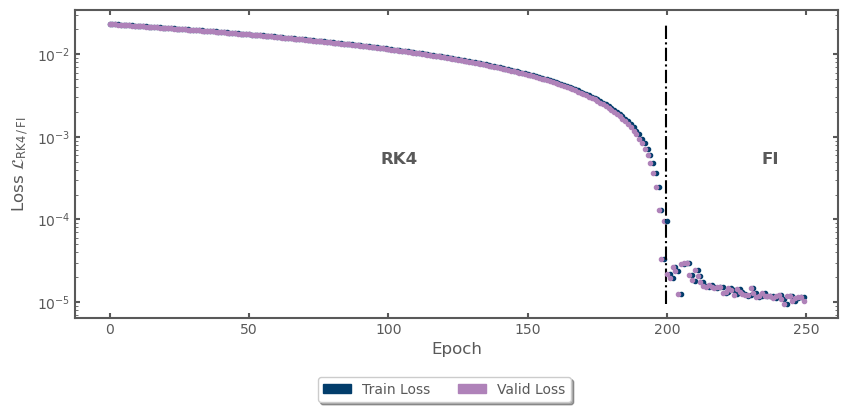

In [26]:
fig = plt.figure(figsize=(9.85,4))

plt.plot(
    np.arange(0,params['Number Epochs']['RK4']), RK4_trainLoss, '.', color = BLUE,
)
plt.plot(
    np.arange(0,params['Number Epochs']['RK4']), RK4_validLoss, '.', color = VIOLET,
)
plt.vlines(params['Number Epochs']['RK4']-0.5, 
    torch.min(torch.cat( [RK4_trainLoss,RK4_validLoss,FI_trainLoss,FI_validLoss], dim=0 )).item(),
    torch.max(torch.cat( [RK4_trainLoss,RK4_validLoss,FI_trainLoss,FI_validLoss], dim=0 )).item(),
    colors = 'k',
    linestyles = 'dashdot'
)
plt.plot(
    params['Number Epochs']['RK4']+np.arange(0,params['Number Epochs']['FI']), FI_trainLoss, '.', color = BLUE,
)
plt.plot(
    params['Number Epochs']['RK4']+np.arange(0,params['Number Epochs']['FI']), FI_validLoss, '.', color = VIOLET,
)

plt.text(
    x = 0.5*(params['Number Epochs']['RK4']/(params['Number Epochs']['RK4']+params['Number Epochs']['FI'])),
    y = 0.5,
    s = "RK4",
    weight = 'bold',
    fontsize = 12,
    transform = plt.gca().transAxes
)
plt.text(
    x = (
        (params['Number Epochs']['RK4']+0.5*params['Number Epochs']['FI']) / 
        (params['Number Epochs']['RK4']+    params['Number Epochs']['FI'])
    ),
    y = 0.5,
    s = "FI",
    weight = 'bold',
    fontsize = 12,
    transform = plt.gca().transAxes
)

plt.yscale('log')
plt.ylabel(r"Loss $\mathcal{L}_{\mathrm{RK4}\,/\,\mathrm{FI}}$", fontsize = 12)
plt.xlabel("Epoch", fontsize = 12)

patch_1 = mpatches.Patch(color = BLUE,  label = r"Train Loss")
patch_2 = mpatches.Patch(color = VIOLET,label = r"Valid Loss")

lgd = fig.legend(handles=[patch_1,patch_2],
    loc='upper center', bbox_to_anchor=(0.5, -0.02),
    fancybox=True, shadow=True, ncol = 3
);

plt.savefig(get_fn("Results/LossPlot",".pdf",params),
          bbox_extra_artists=(lgd,), 
          bbox_inches='tight'
)

In [27]:
lossData_fn = get_fn("Results/Losses",".h5",params)

with h5.File(lossData_fn, 'w') as loss_file:
    loss_file.create_dataset(
        "RK4/train",
        data=RK4_trainLoss.numpy()
    )
    loss_file.create_dataset(
        "RK4/valid",
        data=RK4_validLoss.numpy()
    ) 
    loss_file.create_dataset(
        "FI/train",
        data=FI_trainLoss.numpy()
    )
    loss_file.create_dataset(
        "FI/valid",
        data=FI_validLoss.numpy()
    )

    writeParamsH5(loss_file,params)



# Save the Model

If the model is interesting enough save the model and evaluate it on the test data for publication.

In [28]:
torch.save({
        "NN state":NN.state_dict(),
        "RK4 optimizer state": RK4_optimizer.state_dict(),
        "FI optimizer state": FI_optimizer.state_dict(),
        "params": params
    },
    get_fn("Results/ModelCheckpoint",".pt",params)
)

load the model for evaluation or further training with 

```
checkpoint = torch.load(get_fn("Results/ModelCheckpoint",".pt",params))

NN = create_model(checkpoint['params'])
NN.load_state_dict(checkpoint['NN state'])

flow = Flow( NN, checkpoint['params']['Number Flow Steps'] )

RK4_optimizer = torch.optim.Adam(NN.parameters(),lr = checkpoint['params']['Learning Rate']['RK4'])
RK4_optimizer.load_state_dict(checkpoint['RK4 optimizer state'])

FI_optimizer = torch.optim.Adam(flow.parameters(),lr = checkpoint['params']['Learning Rate']['FI'])
FI_optimizer.load_state_dict(checkpoint['FI optimizer state'])

flow.eval()
# or 
# flow.train(True)
```

In [29]:
flow.eval()

Flow(
  (NN): Equivariance(
    (NN): PRCL(
      (coupling): AffineCoupling(
        (m): Sequential(
          (0): LinearTransformation()
          (1): Softsign()
          (2): LinearTransformation()
        )
        (a): Sequential(
          (0): LinearTransformation()
          (1): Softsign()
          (2): LinearTransformation()
        )
      )
    )
  )
)

Computing Predicion
Computing Actions
Plotting Field Statistis (RK4)
CPU times: user 5.54 s, sys: 23.3 ms, total: 5.56 s
Wall time: 5.33 s


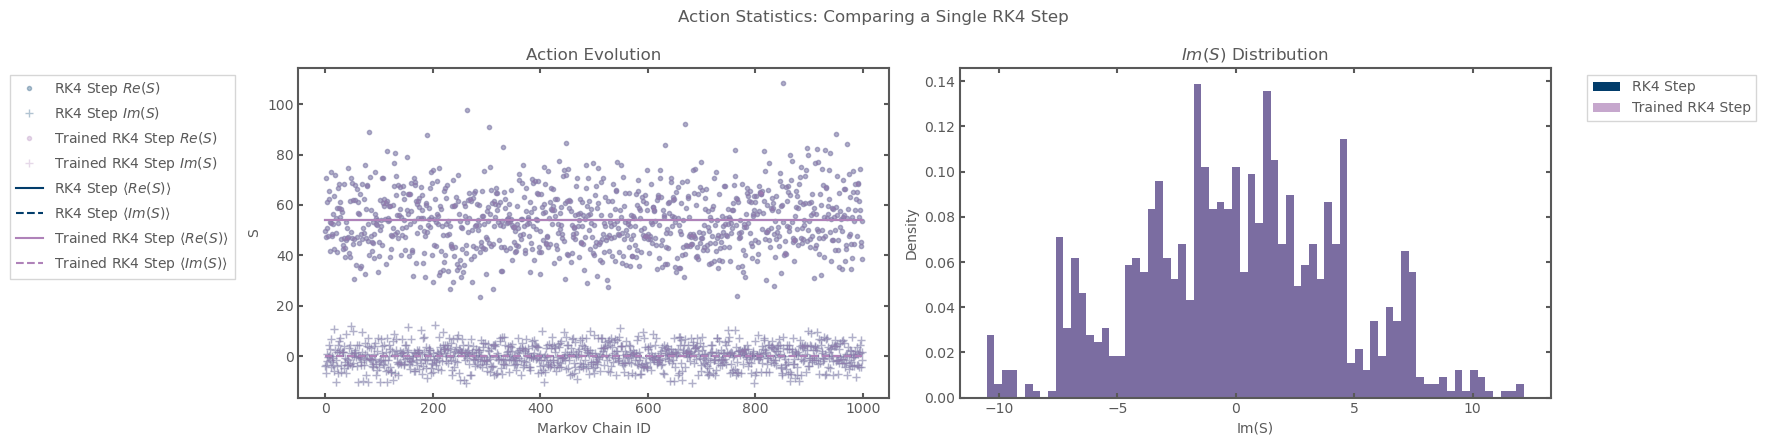

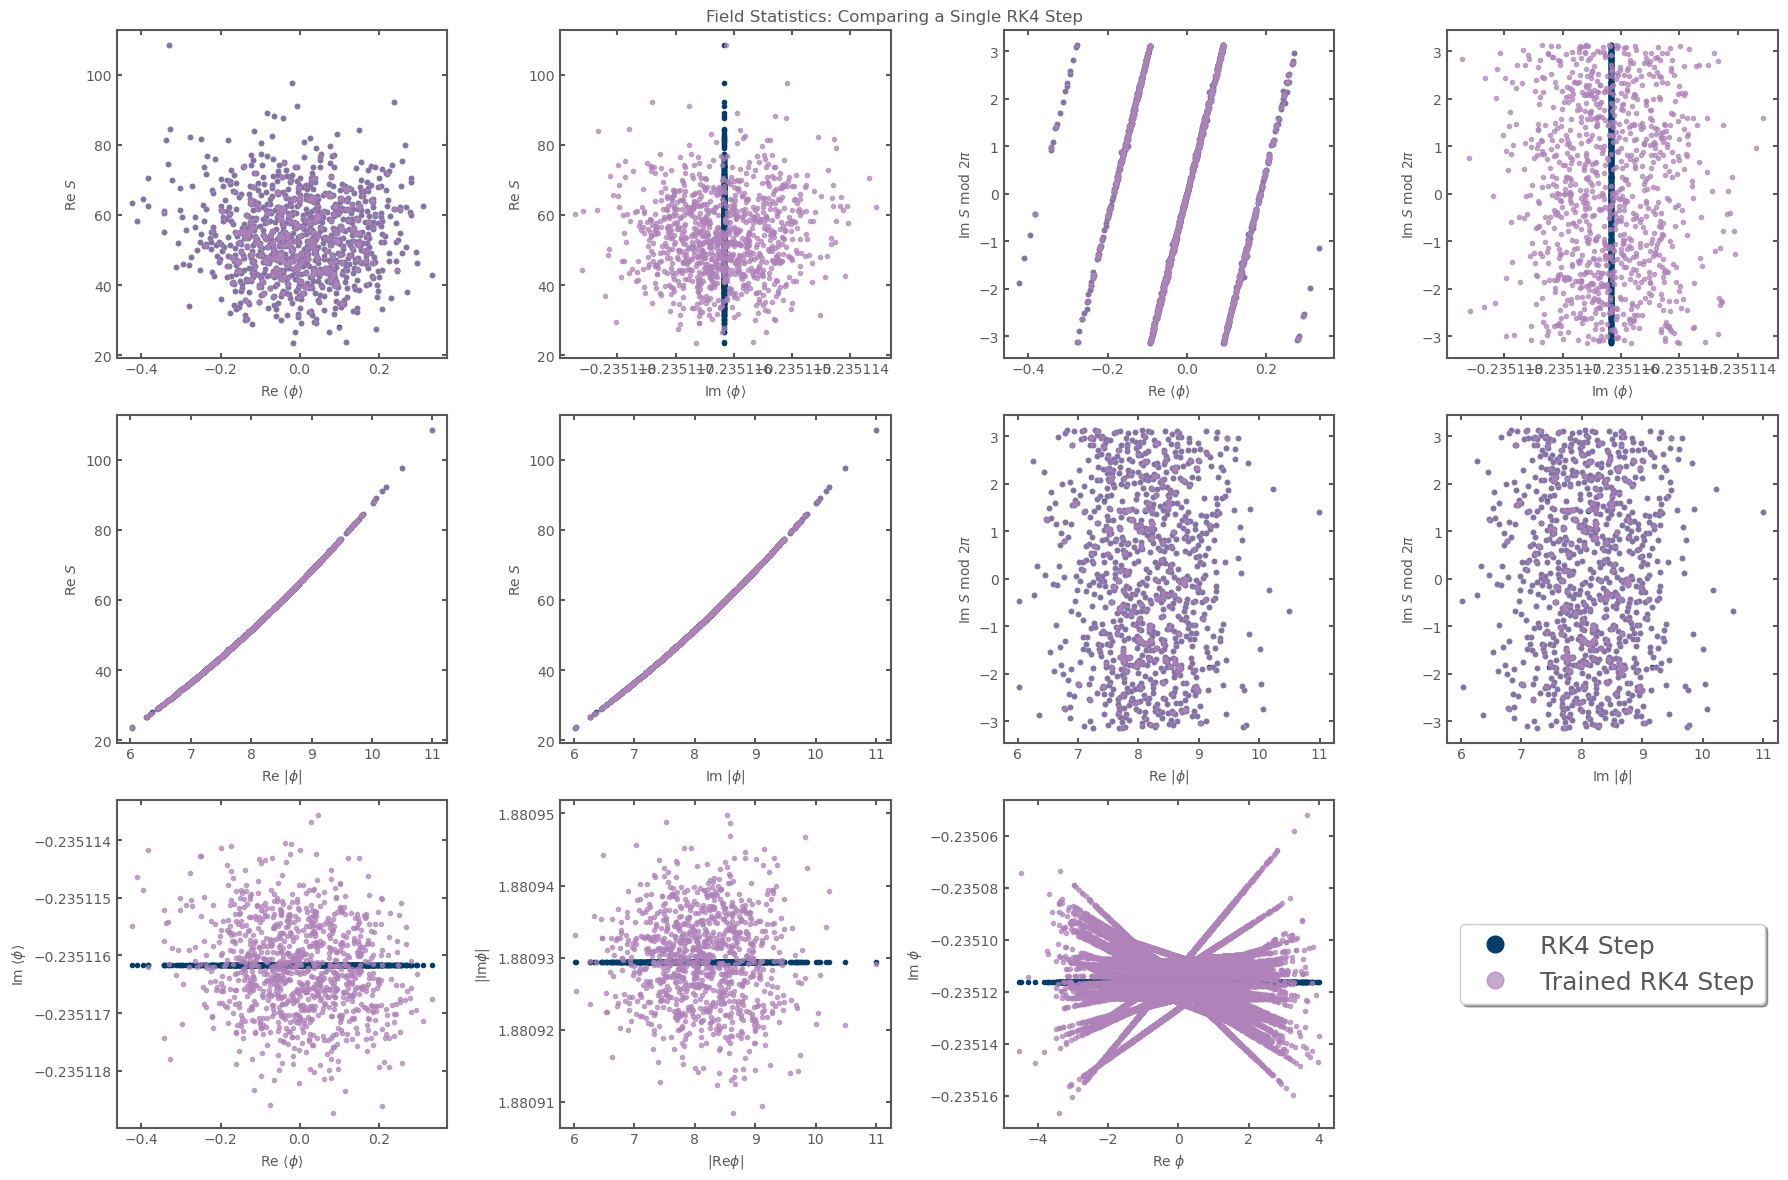

In [32]:
%%time

# Get the isle action from the parameters
lattice = isle.LATTICES[params['lattice']]
lattice.nt(params['Nt'])
action = make_action(lattice, makeIsleParams(params))

V = params['Nt']*2 

print(f"Computing Predicion")
# Evaluate the network
with torch.no_grad():
    RK4Pred,RK4LogDetJ = NN(testData)
    FIPred, FILogDetJ  = flow(testData)

print(f"Computing Actions")
# Compute actions
S_testData = torch.zeros(len(testData), dtype = torch.cdouble)
S_RK4Step  = torch.zeros(len(testData), dtype = torch.cdouble)
S_RK4Pred  = torch.zeros(len(testData), dtype = torch.cdouble)
S_FIPred  = torch.zeros(len(testData), dtype = torch.cdouble)
for cfgID in range(len(testData)):
    # Compute action of test data
    S_testData[cfgID] = action.eval(
        isle.CDVector(testData[cfgID].reshape(V).numpy())
    )
    # Compute action of test target data (single RK4 step)
    S_RK4Step[cfgID] = action.eval(
        isle.CDVector(testTargetData[cfgID].reshape(V).numpy())
    )
    # Compute action of the NN prediction (single trained RK4 step)
    S_RK4Pred[cfgID] = action.eval(
        isle.CDVector(RK4Pred[cfgID].reshape(V).numpy())
    )
    # Compute action of the flow prediction (N trained RK4 steps)
    S_FIPred[cfgID] = action.eval(
        isle.CDVector(FIPred[cfgID].reshape(V).numpy())
    )
    
print(f"Plotting Field Statistis (RK4)")
    
# plot field statistics for this model
RK4phys,RK4stat = field_statistic(
    confs_I=testTargetData.reshape(len(testData),V), 
    confs_C=RK4Pred.reshape(len(testData),V), 
    action_I=S_RK4Step, 
    action_C=S_RK4Pred, 
    plot_layout_dict={"I str":"RK4 Step", 
                      "C str":"Trained RK4 Step", 
                      "title":"Comparing a Single RK4 Step"
    },
    param=params
)

RK4stat.savefig(get_fn("Results/NNFieldStats",".pdf",params))

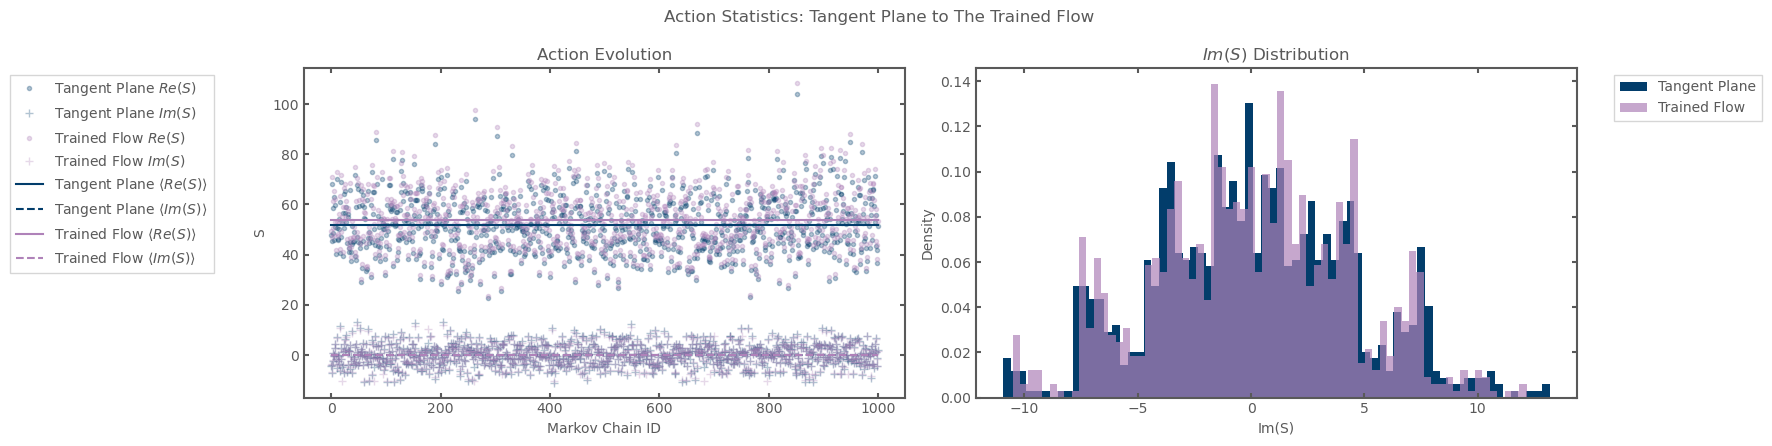

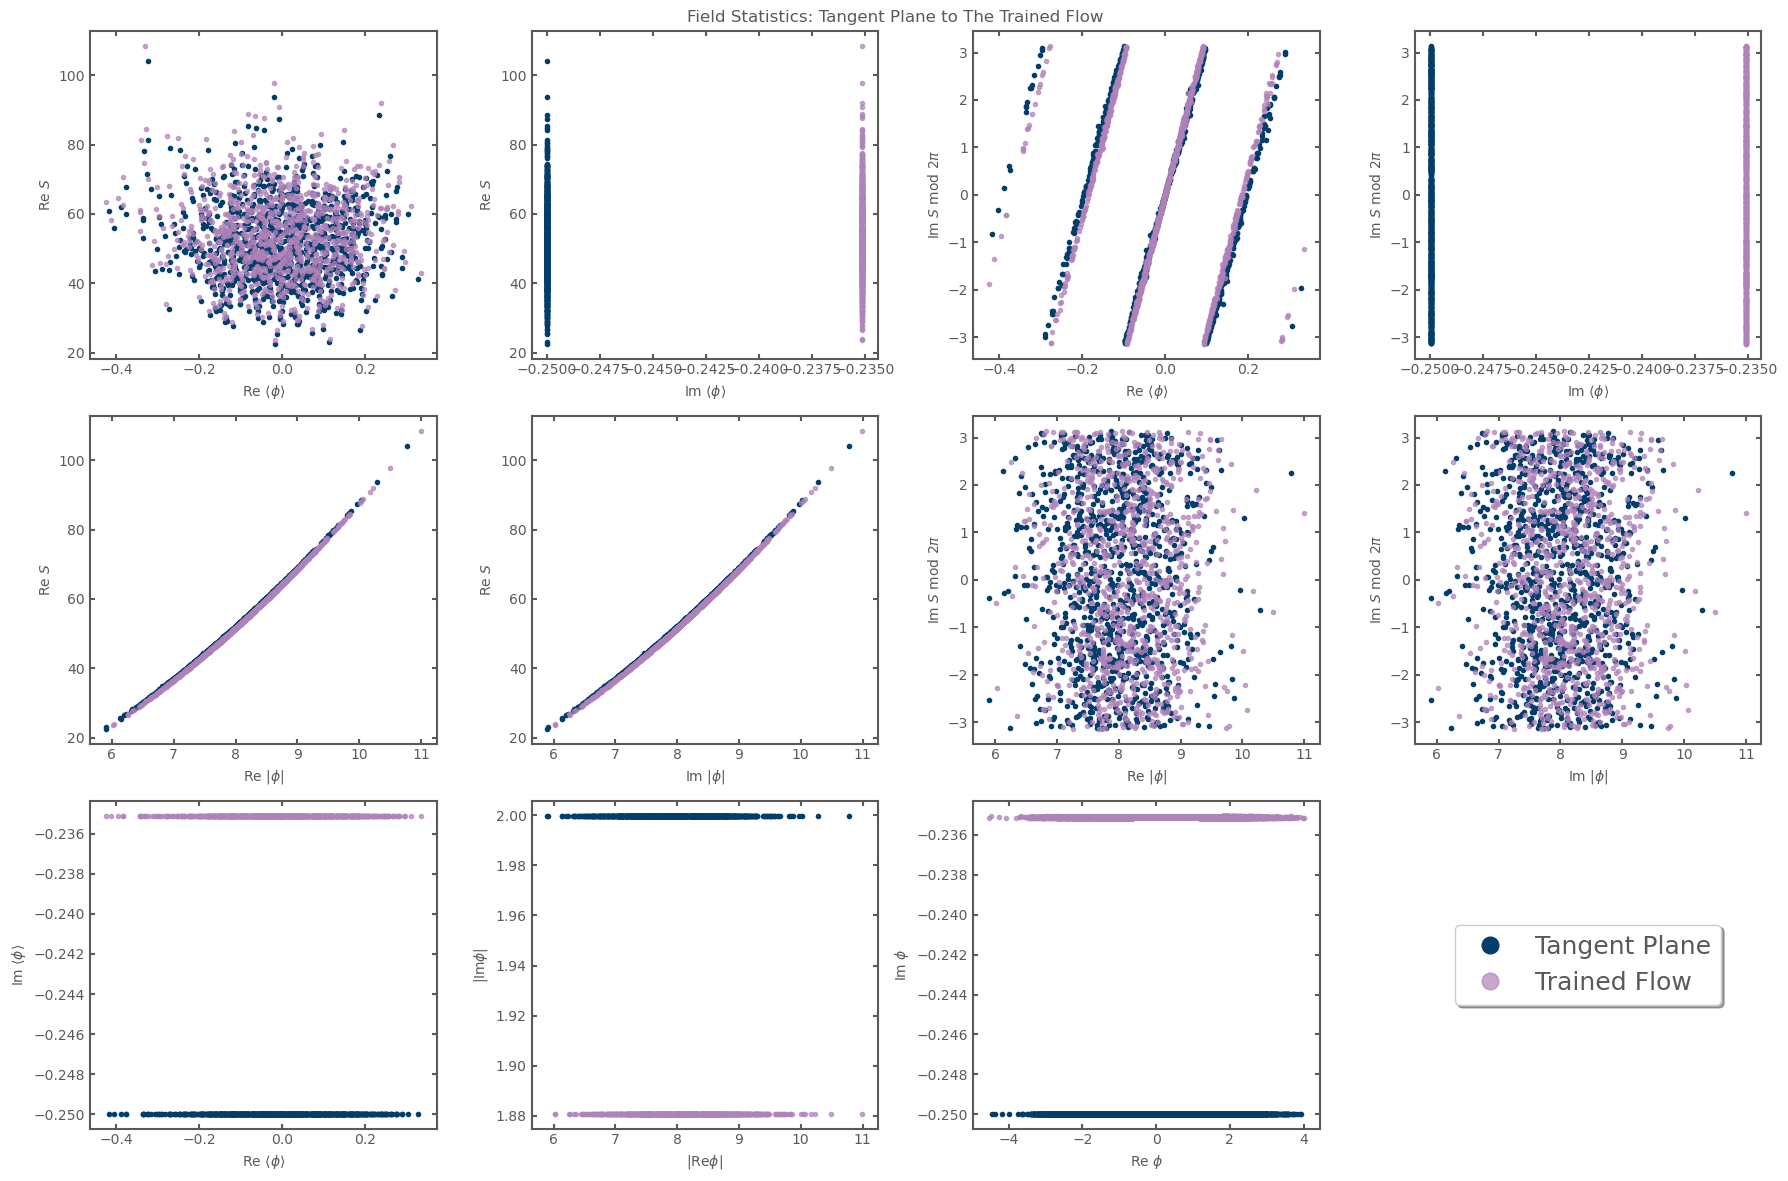

In [33]:
# plot field statistics for this model
FIphys,FIstat = field_statistic(
    confs_I=testData.reshape(len(testData),V), 
    confs_C=FIPred.reshape(len(testData),V), 
    action_I=S_testData, 
    action_C=S_FIPred, 
    plot_layout_dict={"I str":"Tangent Plane", 
                      "C str":"Trained Flow", 
                      "title":"Tangent Plane to The Trained Flow"
    }, 
    param=params
)
RK4stat.savefig(get_fn("Results/NNFlowFieldStats",".pdf",params))

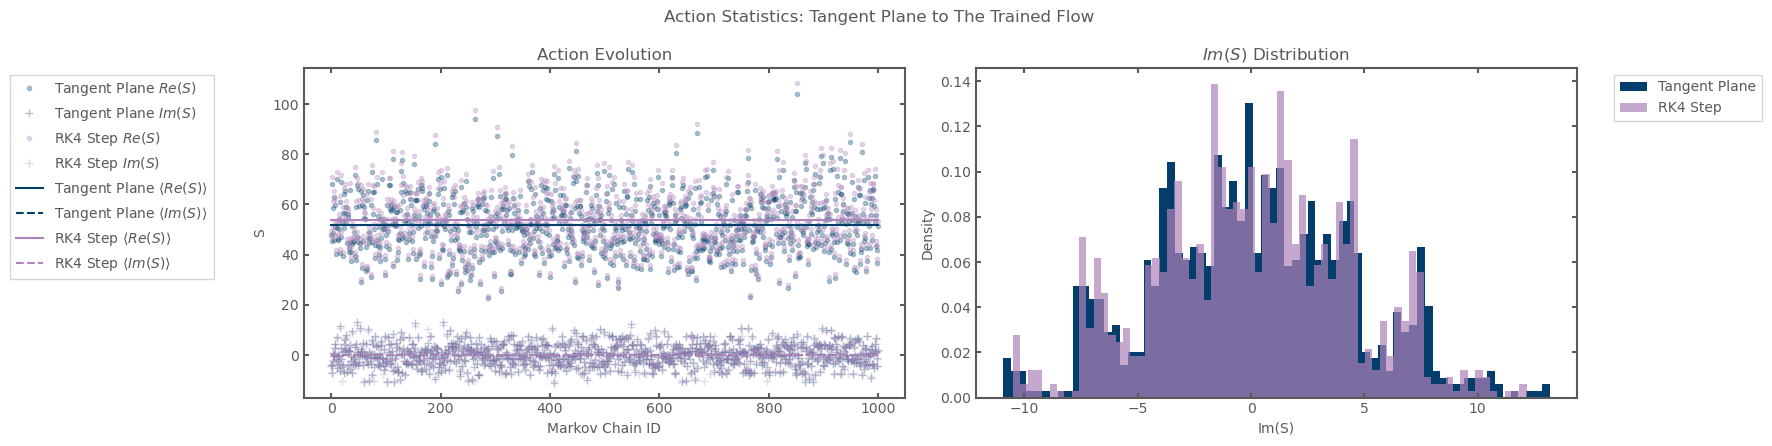

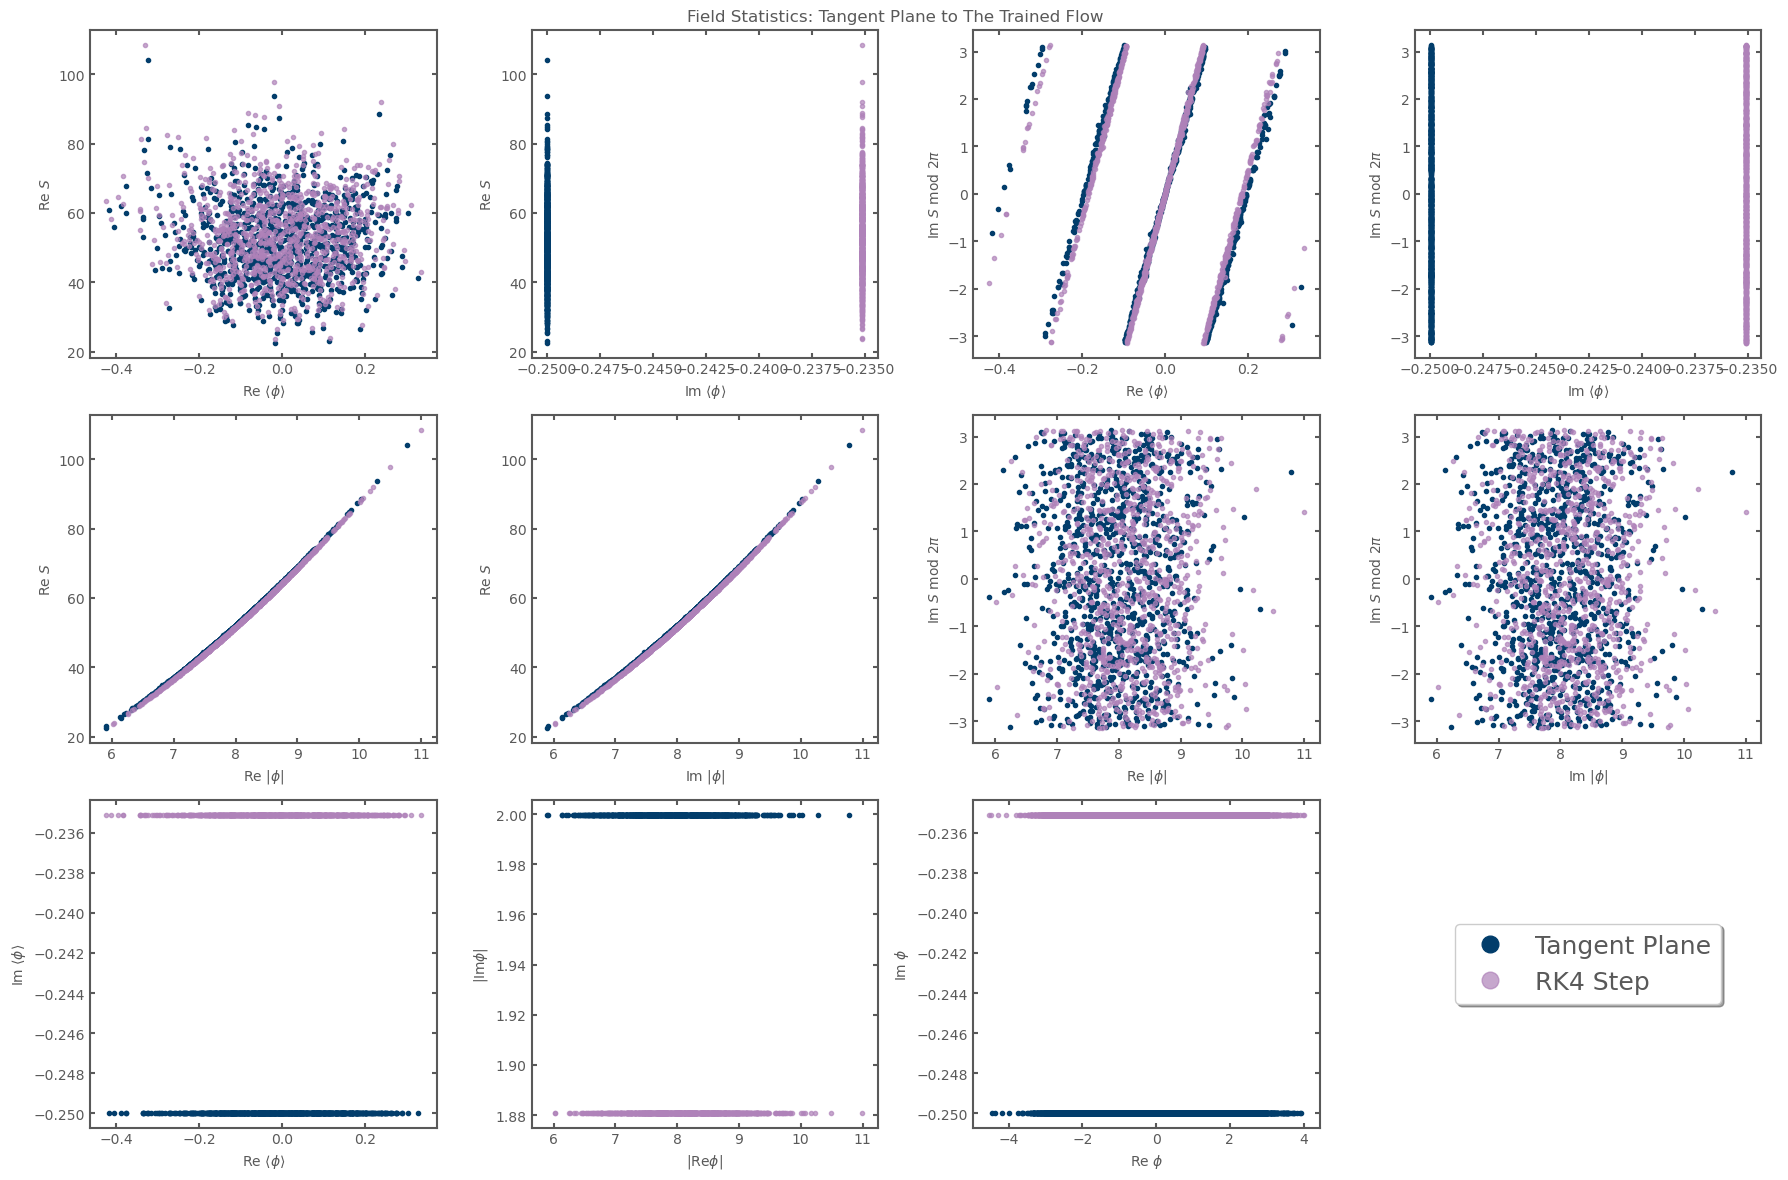

In [35]:
# plot field statistics for The training data model
FIphys,FIstat = field_statistic(
    confs_I=testData.reshape(len(testData),V), 
    confs_C=testTargetData.reshape(len(testData),V), 
    action_I=S_testData, 
    action_C=S_RK4Step, 
    plot_layout_dict={"I str":"Tangent Plane", 
                      "C str":"RK4 Step", 
                      "title":"Tangent Plane to Single RK4 Step"
    }, 
    param=params
)
RK4stat.savefig(get_fn("Results/TestDataFieldStats",".pdf",params))

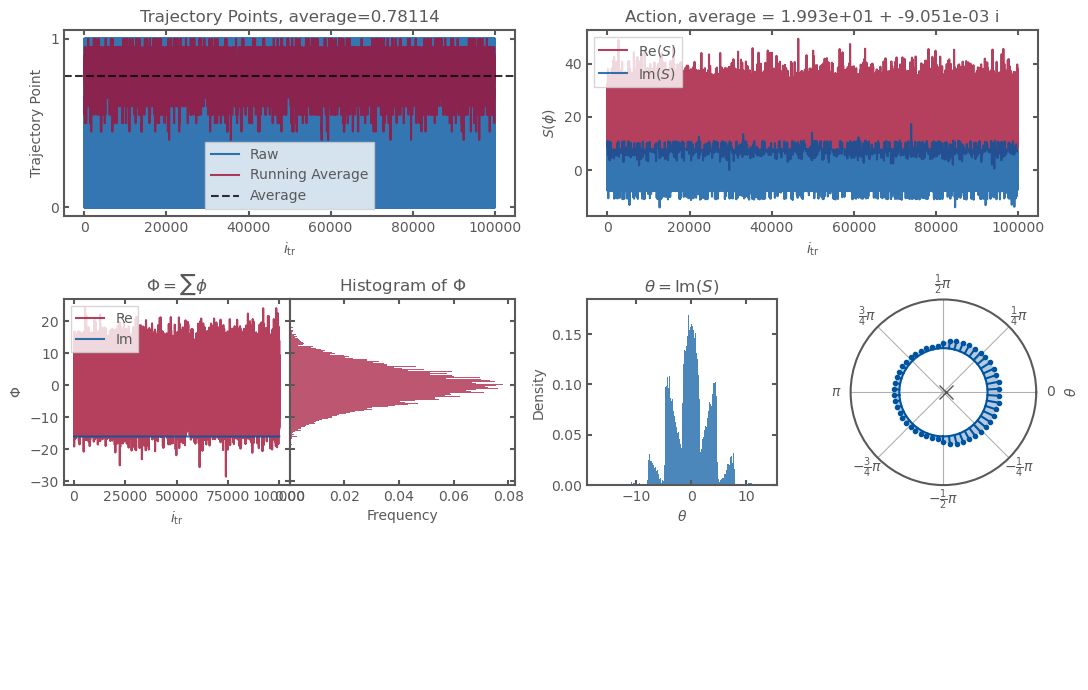

In [36]:
fig = overview("Results/2Site_HMC_Simulation.h5")
# fig.savefig("Results/2Site_HMCSimulationOverview.pdf")

In [39]:
# perform the simulation with ML HMC
f = Path(get_fn("Results/MLHMC_Simulation",".h5",params))

if f.exists():
    f.unlink()

MLHMC_params = params.copy()
# set number of molecular dynamics step 
MLHMC_params['MD_steps'] = 4
# set molecular dynamics trajectory length
MLHMC_params['MD_trajectory_length'] = 1.5
MLHMC_params['nTraj'] = 1_000_000
MLHMC_params['bTherm'] = 1_000
MLHMC_params['sTherm'] = 10

ML_HMC(flow,f,makeIsleParams(MLHMC_params))

with h5.File(f, 'a') as h5f:
    writeParamsH5(h5f,MLHMC_params)

HMC evolution  ETA: ??:??:?? (   1/1000) 
HMC evolution  ETA: 12:53:18 (  10/1000) 
HMC evolution  ETA: 12:53:18 (  20/1000) 
HMC evolution  ETA: 12:53:18 (  30/1000) 
HMC evolution  ETA: 12:53:18 (  40/1000) 
HMC evolution  ETA: 12:53:18 (  50/1000) 
HMC evolution  ETA: 12:53:18 (  60/1000) 
HMC evolution  ETA: 12:53:18 (  70/1000) 
HMC evolution  ETA: 12:53:18 (  80/1000) 
HMC evolution  ETA: 12:53:18 (  90/1000) 
HMC evolution  ETA: 12:53:18 ( 100/1000) 
HMC evolution  ETA: 12:53:18 ( 110/1000) 
HMC evolution  ETA: 12:53:18 ( 120/1000) 
HMC evolution  ETA: 12:53:18 ( 130/1000) 
HMC evolution  ETA: 12:53:18 ( 140/1000) 
HMC evolution  ETA: 12:53:18 ( 150/1000) 
HMC evolution  ETA: 12:53:18 ( 160/1000) 
HMC evolution  ETA: 12:53:18 ( 170/1000) 
HMC evolution  ETA: 12:53:18 ( 180/1000) 
HMC evolution  ETA: 12:53:18 ( 190/1000) 
HMC evolution  ETA: 12:53:18 ( 200/1000) 
HMC evolution  ETA: 12:53:18 ( 210/1000) 
HMC evolution  ETA: 12:53:18 ( 220/1000) 
HMC evolution  ETA: 12:53:18 ( 230

HMC evolution  ETA: 13:15:10 ( 820000/1000000) 
HMC evolution  ETA: 13:15:10 ( 830000/1000000) 
HMC evolution  ETA: 13:15:10 ( 840000/1000000) 
HMC evolution  ETA: 13:15:11 ( 850000/1000000) 
HMC evolution  ETA: 13:15:12 ( 860000/1000000) 
HMC evolution  ETA: 13:15:12 ( 870000/1000000) 
HMC evolution  ETA: 13:15:12 ( 880000/1000000) 
HMC evolution  ETA: 13:15:13 ( 890000/1000000) 
HMC evolution  ETA: 13:15:13 ( 900000/1000000) 
HMC evolution  ETA: 13:15:15 ( 910000/1000000) 
HMC evolution  ETA: 13:15:16 ( 920000/1000000) 
HMC evolution  ETA: 13:15:17 ( 930000/1000000) 
HMC evolution  ETA: 13:15:18 ( 940000/1000000) 
HMC evolution  ETA: 13:15:19 ( 950000/1000000) 
HMC evolution  ETA: 13:15:19 ( 960000/1000000) 
HMC evolution  ETA: 13:15:20 ( 970000/1000000) 
HMC evolution  ETA: 13:15:20 ( 980000/1000000) 
HMC evolution  ETA: 13:15:20 ( 990000/1000000) 
HMC evolution  ETA: 13:15:21 (1000000/1000000) 
HMC evolution finished after 1323.2s at 13:15:21 


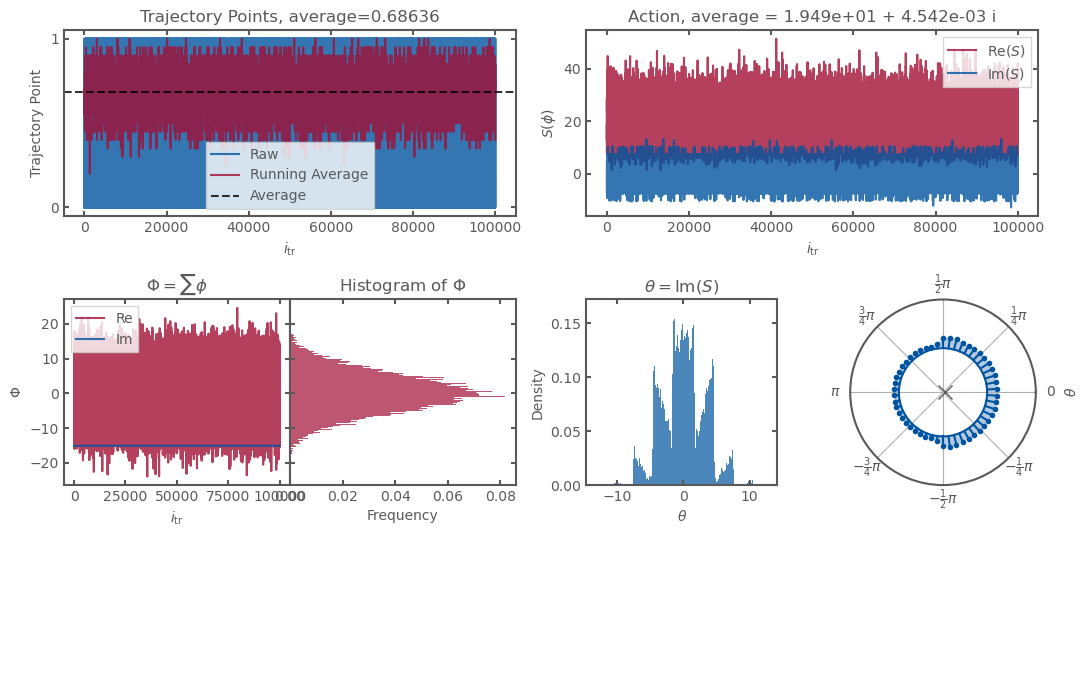

In [40]:
fig = overview(f)
fig.savefig(get_fn("Results/MLHMCSimulationOverview",".pdf",params))

In [41]:
measure_correlators(get_fn("Results/MLHMC_Simulation",".h5",params),MLHMC_params)

Measurements  ETA: ??:??:?? (     1/100000) 
Measurements  ETA: 13:21:03 (  1000/100000) 
Measurements  ETA: 13:21:01 (  2000/100000) 
Measurements  ETA: 13:20:59 (  3000/100000) 
Measurements  ETA: 13:21:00 (  4000/100000) 
Measurements  ETA: 13:20:59 (  5000/100000) 
Measurements  ETA: 13:20:58 (  6000/100000) 
Measurements  ETA: 13:20:58 (  7000/100000) 
Measurements  ETA: 13:20:59 (  8000/100000) 
Measurements  ETA: 13:20:59 (  9000/100000) 
Measurements  ETA: 13:20:59 ( 10000/100000) 
Measurements  ETA: 13:20:59 ( 11000/100000) 
Measurements  ETA: 13:20:59 ( 12000/100000) 
Measurements  ETA: 13:20:59 ( 13000/100000) 
Measurements  ETA: 13:20:59 ( 14000/100000) 
Measurements  ETA: 13:20:59 ( 15000/100000) 
Measurements  ETA: 13:20:59 ( 16000/100000) 
Measurements  ETA: 13:20:59 ( 17000/100000) 
Measurements  ETA: 13:20:59 ( 18000/100000) 
Measurements  ETA: 13:20:59 ( 19000/100000) 
Measurements  ETA: 13:20:59 ( 20000/100000) 
Measurements  ETA: 13:20:59 ( 21000/100000) 
Measuremen

In [43]:
%%time
HMC_res1000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 1_000, Nbst = 100)

CPU times: user 30.9 ms, sys: 106 ms, total: 137 ms
Wall time: 137 ms


In [44]:
%%time
HMC_res10000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 10_000, Nbst = 100)

CPU times: user 398 ms, sys: 96 ms, total: 494 ms
Wall time: 496 ms


In [45]:
%%time
HMC_res100000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 100_000, Nbst = 100)

CPU times: user 3.65 s, sys: 1.13 s, total: 4.78 s
Wall time: 4.79 s


In [47]:
%%time
MLHMC_res1000 = estimate_correlators(fn = get_fn("Results/MLHMC_Simulation",".h5",params), Nconf = 1_000, Nbst = 100)

CPU times: user 30.3 ms, sys: 96.3 ms, total: 127 ms
Wall time: 126 ms


In [48]:
%%time
MLHMC_res10000 = estimate_correlators(fn = get_fn("Results/MLHMC_Simulation",".h5",params), Nconf = 10_000, Nbst = 100)

CPU times: user 395 ms, sys: 110 ms, total: 505 ms
Wall time: 505 ms


In [49]:
%%time
MLHMC_res100000 = estimate_correlators(fn = get_fn("Results/MLHMC_Simulation",".h5",params), Nconf = 100_000, Nbst = 100)

CPU times: user 3.68 s, sys: 1.13 s, total: 4.81 s
Wall time: 4.82 s


In [50]:
print(f"Stat Power HMC 1_000  : {HMC_res1000['StatPower'][0]:.2e} +/- {HMC_res1000['StatPower'][1]:.2e}")
print(f"Stat Power HMC 10_000 : {HMC_res10000['StatPower'][0]:.2e} +/- {HMC_res10000['StatPower'][1]:.2e}")
print(f"Stat Power HMC 100_000: {HMC_res100000['StatPower'][0]:.2e} +/- {HMC_res100000['StatPower'][1]:.2e}")

Stat Power HMC 1_000  : 5.67e-02 +/- 2.02e-02
Stat Power HMC 10_000 : 5.27e-02 +/- 6.11e-03
Stat Power HMC 100_000: 5.57e-02 +/- 2.25e-03


In [51]:
print(f"Stat Power MLHMC 1_000  : {MLHMC_res1000['StatPower'][0]:.2e} +/- {MLHMC_res1000['StatPower'][1]:.2e}")
print(f"Stat Power MLHMC 10_000 : {MLHMC_res10000['StatPower'][0]:.2e} +/- {MLHMC_res10000['StatPower'][1]:.2e}")
print(f"Stat Power MLHMC 100_000: {MLHMC_res100000['StatPower'][0]:.2e} +/- {MLHMC_res100000['StatPower'][1]:.2e}")

Stat Power MLHMC 1_000  : 5.37e-02 +/- 1.75e-02
Stat Power MLHMC 10_000 : 3.13e-02 +/- 7.13e-03
Stat Power MLHMC 100_000: 3.73e-02 +/- 2.34e-03


In [52]:
with h5.File("ExactData/TwoSites.h5") as h5f:
    tau = h5f["tau"][()]
    exactCorr = h5f["/2Site/exact"][()]

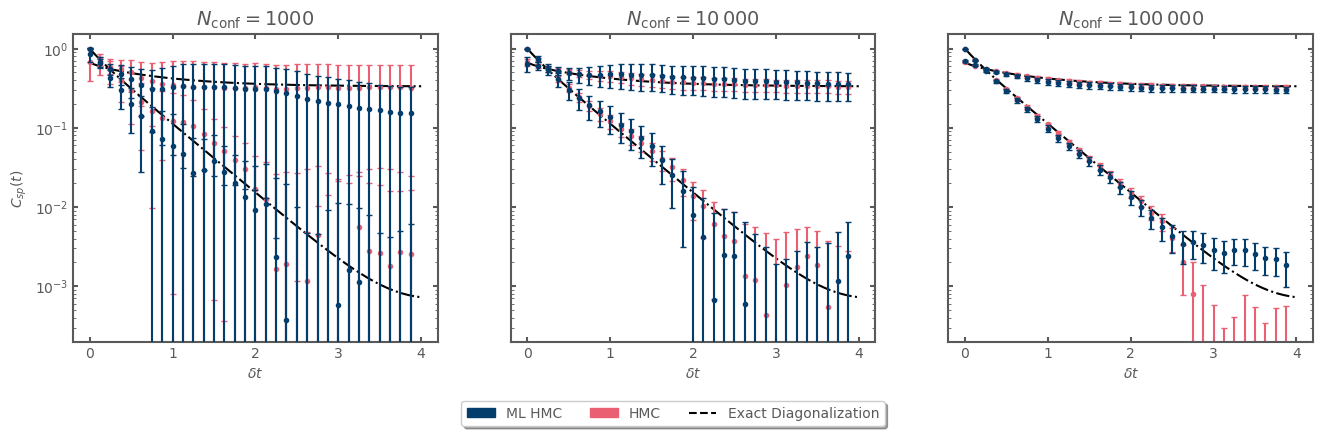

In [54]:
fig, axs = plt.subplots(1,3, figsize = (16,4),sharey = True)

simtau = np.arange(0,params['beta'],params['beta']/params['Nt'])

for i in range(2):
    axs[0].errorbar(
        simtau,HMC_res1000["Corr"][0][i,:].real, yerr=HMC_res1000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )    
    axs[0].errorbar(
        simtau,MLHMC_res1000["Corr"][0][i,:].real, yerr=MLHMC_res1000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[0].plot(
        tau, exactCorr[i], 'k-.', zorder=1
    )
    
    axs[1].errorbar(
        simtau,HMC_res10000["Corr"][0][i,:].real, yerr=HMC_res10000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )    
    axs[1].errorbar(
        simtau,MLHMC_res10000["Corr"][0][i,:].real, yerr=MLHMC_res10000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[1].plot(
        tau, exactCorr[i], 'k-.',zorder=1
    )
    
    axs[2].errorbar(
        simtau,HMC_res100000["Corr"][0][i,:].real, yerr=HMC_res100000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )
    axs[2].errorbar(
        simtau,MLHMC_res100000["Corr"][0][i,:].real, yerr=MLHMC_res100000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[2].plot(
        tau, exactCorr[i], 'k-.',zorder=1
    )

patch_1 = mpatches.Patch(color = BLUE,label = r"ML HMC")
patch_2 = mpatches.Patch(color = RED,label = r"HMC")
patch_3 = mlines.Line2D([], [], color = 'k', ls='--', label="Exact Diagonalization")

lgd = fig.legend(handles=[patch_1,patch_2,patch_3],
    loc='upper center', bbox_to_anchor=(0.5, -0.02),
    fancybox=True, shadow=True, ncol = 3
);

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r"$\delta t$")

axs[0].set_ylabel(r"$C_{sp}(t)$");
axs[0].set_title("$N_{\mathrm{conf}} = 1000$", fontsize=14);
axs[1].set_title("$N_{\mathrm{conf}} = 10\, 000$", fontsize=14);
axs[2].set_title("$N_{\mathrm{conf}} = 100\, 000$", fontsize=14);


fig.savefig(get_fn("Results/2Site_Correlators", ".pdf", params),
          bbox_extra_artists=(lgd,), 
          bbox_inches='tight'
)


In [57]:
%%time
Nconfs = np.arange(1000,100_001,1000)
StatPowers_est = np.zeros(shape = (2,len(Nconfs)))
StatPowers_err = np.zeros(shape = (2,len(Nconfs)))
for i,Nconf in enumerate(Nconfs):
    StatPowers_est[0,i], StatPowers_err[0,i] = estimate_statistical_power(
        fn = "Results/2Site_HMC_Simulation.h5", 
        Nconf = Nconf, 
        Nbst = 100
    )
    StatPowers_est[1,i], StatPowers_err[1,i] = estimate_statistical_power(
        fn = get_fn("Results/MLHMC_Simulation",".h5",params), 
        Nconf = Nconf, 
        Nbst = 100
    )

CPU times: user 13.7 s, sys: 43.3 ms, total: 13.8 s
Wall time: 13.8 s


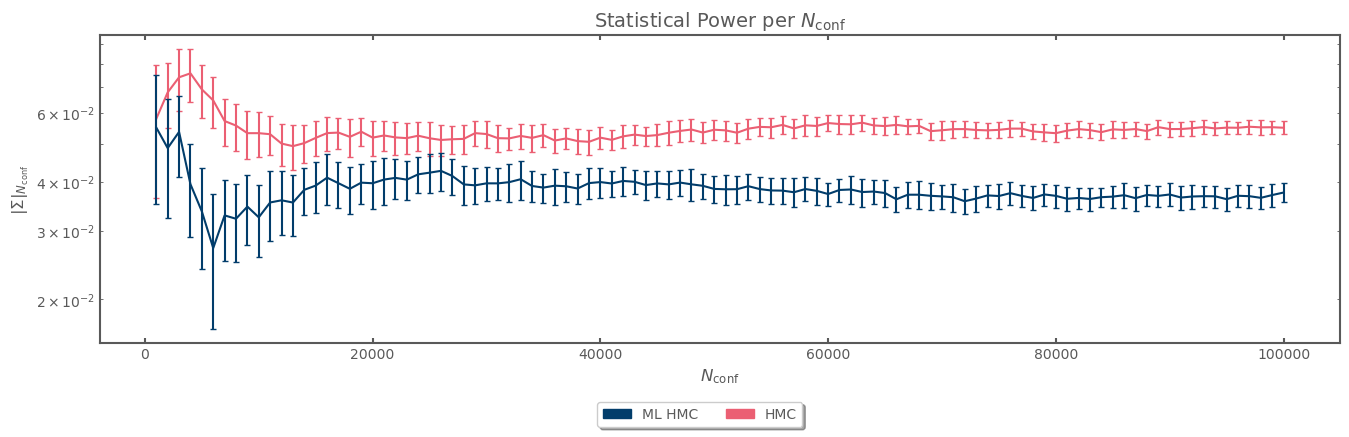

In [58]:
fig = plt.figure(figsize = (16,4) )
plt.errorbar(
    Nconfs, StatPowers_est[0], yerr = StatPowers_err[0], capsize = 2, color = RED ,zorder = 1
)
plt.errorbar(
    Nconfs, StatPowers_est[1], yerr = StatPowers_err[1], capsize = 2, color = BLUE ,zorder = 2
)
plt.yscale('log')
plt.ylabel(r"$\left\vert \Sigma \right\vert_{N_{\mathrm{conf}}}$", fontsize = 12)
plt.xlabel(r"$N_{\mathrm{conf}}$", fontsize = 12)
tit = plt.title(r"Statistical Power per $N_{\mathrm{conf}}$", fontsize = 14)
patch_1 = mpatches.Patch(color = BLUE,label = r"ML HMC")
patch_2 = mpatches.Patch(color = RED,label = r"HMC")
lgd = fig.legend(handles=[patch_1,patch_2],
    loc='upper center', bbox_to_anchor=(0.5, -0.02),
    fancybox=True, shadow=True, ncol = 2
);

fig.savefig(get_fn("Results/Statpower",".pdf",params),
          bbox_extra_artists=(lgd,tit),
          bbox_inches='tight'
)
